# TP1 - Détéctions de points d'intêrets

In [7]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.ndimage as ndi
import scipy.signal as sig
from skimage.io import imread,imshow
from skimage.color import rgb2gray
import cv2



'''
from scipy import signal as sig,ndimage
import numpy as np
from skimage.io import imread,imshow
from skimage.color import rgb2gray 
'''

'\nfrom scipy import signal as sig,ndimage\nimport numpy as np\nfrom skimage.io import imread,imshow\nfrom skimage.color import rgb2gray \n'

## Exercice 1 - Détection de points d'intérêts

### 1 - Détecteur de Harris


### Avec une fenêtre de pondération rectangulaire

In [8]:
def detection_harris_rectangle(img_path,rot,window_size=3,k=0.02):   
    img = imread(img_path)
    if rot != 0 :
        img= ndi.rotate(img,rot, reshape=False)
        
    img_gray=rgb2gray(img) # ---> rgb2gray normalise la matrice

    Sobel_x = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]]) # filtre de sobel pour la dérivée en x 
    Sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) # filtre de sobel pour la dérivée en y

    Ix = sig.convolve2d(img_gray, Sobel_x, mode='same') # convolution par le filtre de Sobel
    Iy = sig.convolve2d(img_gray, Sobel_y, mode='same')

    Ix2= np.square(Ix) # les trois calculs pour la matrice M
    Iy2=np.square(Iy)
    IxIy= (Ix*Iy)

    img_copy_for_corners = np.copy(img) # on crée une copie pour ne pas altérer l'imgae d'originie
    count = 0

    height, width = img_gray.shape

    
    Ix2_sum = ndi.convolve(Ix2, np.ones((window_size, window_size))) # on calcule la somme des carrés des dérivées à chaque pixel
    Iy2_sum = ndi.convolve(Iy2, np.ones((window_size, window_size)))
    IxIy_sum = ndi.convolve(IxIy, np.ones((window_size, window_size)))

    det_M = Ix2_sum * Iy2_sum - IxIy_sum ** 2  #on calcule le determinant et la trace de la matrice M à chaque pixel
    trace_M = Ix2_sum + Iy2_sum

    harris_response = det_M - k * trace_M ** 2

    threshold = 0.01 * harris_response.max() # on seuil la réponse pour avoir les points d'intérêts
    for x in range(height):
        for y in range(width):
            if harris_response[x, y] > threshold:
                img_copy_for_corners[x, y] = [255, 0, 0] # on met en rouge les points d'intérêts
                count += 1

    return img_copy_for_corners, count


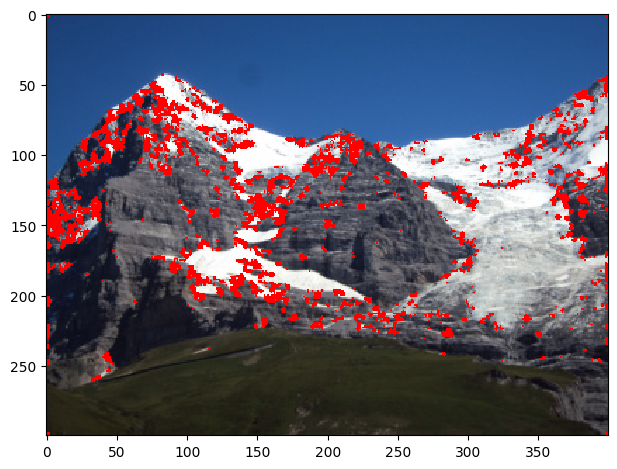

In [64]:

img = "M1.JPG"

coins_brute,count_rect = detection_harris_rectangle(img,0)
imshow(coins_brute)


### Fonction pour la suppression des non-maxima locaux

In [61]:
def sup_non_maxima_optimized(img: np.ndarray, img_originale_path: str) -> np.ndarray:
    
    # On lit l'image originale
    img_originale = imread(img_originale_path)
    # On convertit l'image en niveaux de gris
    img_gray = rgb2gray(img)
    # On crée une copie de l'image avec les points d'intérêts
    image_avec_pt = np.copy(img)

    # On récupère la largeur et la hauteur de l'image
    width = np.shape(img_gray)[1]
    height = np.shape(img_gray)[0]

    # On crée un kernel de 3x3 avec des 1 partout sauf au centre
    kernel = np.ones((3, 3))
    kernel[1, 1] = 0

    # On calcule le maximum des pixels voisins pour chaque pixel de l'image
    max_neighborhood = np.max(np.stack([ndi.maximum_filter(img_gray, footprint=kernel, mode='constant', cval=0.0),
                                        ndi.maximum_filter(img_gray, footprint=kernel.T, mode='constant', cval=0.0)]), axis=0)

    # On remplace les pixels qui ne sont pas des maximums locaux par les pixels de l'image originale
    image_avec_pt[max_neighborhood > img_gray] = img_originale[max_neighborhood > img_gray]

    # On compte le nombre de points d'intérêts supprimés
    count_suppr = np.sum(image_avec_pt[:, :, 0] == 255)

    return image_avec_pt, count_suppr


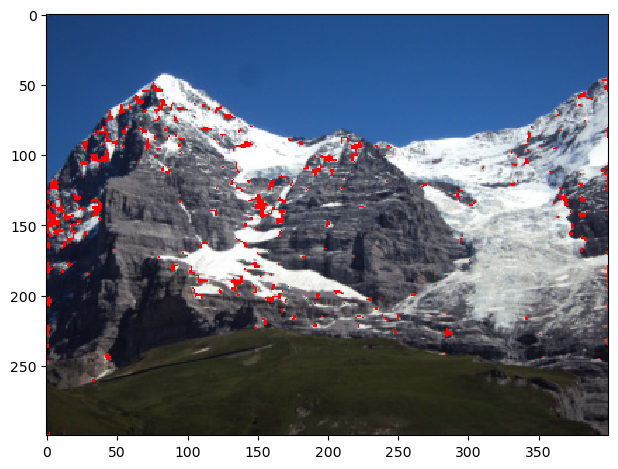

In [110]:
img_suppr,c_supr_rect= sup_non_maxima_optimized(coins_brute,img)
imshow(img_suppr)

### Avec une fenêtre de pondération gaussienne

In [62]:
def detection_harris_gauss_optimized(img_path, rot,window_size=3,k=0.04,sigma=2):
    img = imread(img_path)
    if rot != 0:
        img = ndi.rotate(img, rot, reshape=False)
    img_gray = rgb2gray(img)

    width = np.shape(img_gray)[1]  # largeur et hauteurs de l'image
    height = np.shape(img_gray)[0]
    Sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])  # filtre de sobel pour la dérivée en x
    Sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])  # filtre de sobel pour la dérivée en y

    Ix = sig.convolve2d(img_gray, Sobel_x, mode='same')  # convolution par le filtre de Sobel
    Iy = sig.convolve2d(img_gray, Sobel_y, mode='same')

    Ix2 = np.square(Ix)  # les trois calculs pour la matrice M
    Iy2 = np.square(Iy)
    IxIy = (Ix * Iy)

    
    kernel_size = window_size # Adjust the kernel size as needed
    gaussian_kernel = np.zeros((kernel_size, kernel_size))
    for y in range(kernel_size):
        for x in range(kernel_size):
            gaussian_kernel[y, x] = 1 / (2 * np.pi * sigma ** 2) * np.exp(
                -((x - (kernel_size - 1) / 2) ** 2 + (y - (kernel_size - 1) / 2) ** 2) / (2 * sigma ** 2))

    # Convolve the matrices with the Gaussian kernel
    Ix2gauss = sig.convolve2d(Ix2, gaussian_kernel, boundary='fill', mode='same')
    Iy2gauss = sig.convolve2d(Iy2, gaussian_kernel, boundary='fill', mode='same')
    IxIygauss = sig.convolve2d(IxIy, gaussian_kernel, boundary='fill', mode='same')

    img_copy_for_corners = np.copy(img)  # on créer une copie pour ne pas altérer l'image d'origine
    count = 0

    deter = (Ix2gauss * Iy2gauss) - (IxIygauss ** 2)
    trace = Ix2gauss + Iy2gauss
    C = deter - k * (trace ** 2)  # calcul du critère pour le seuillage des points d'intérêts
    threshold = 0.01
    img_copy_for_corners[C > threshold] = [255, 0, 0]  # on met en rouge les points d'intérêts
    count = np.sum(C > threshold)

    return img_copy_for_corners, count


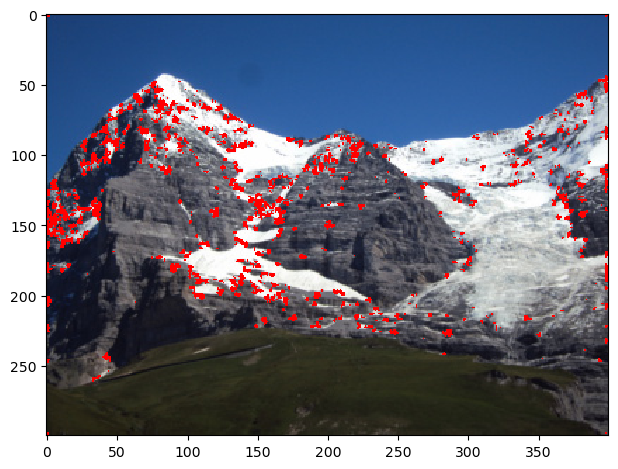

In [148]:
coins_brute_gauss,count_gauss= detection_harris_gauss_optimized(img,0)
imshow(coins_brute_gauss)

### Avec suppression :

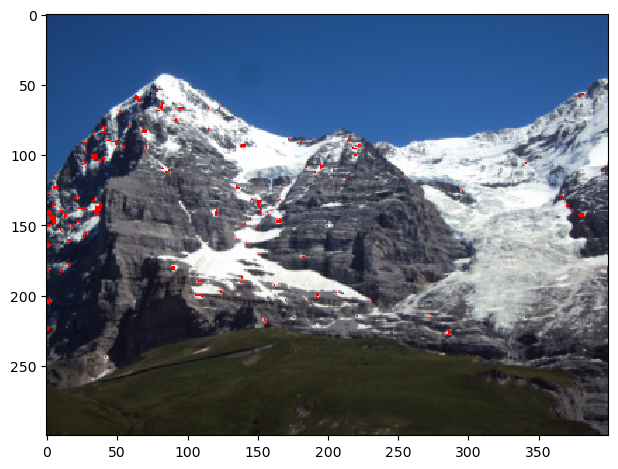

In [149]:
img_suppr_gauss,c_supr_gauss = sup_non_maxima_optimized(coins_brute_gauss,img)
imshow(img_suppr_gauss)

### Influence du type de fenêtre de pondération, de sa taille ainsi que du paramètre k dans la détection de point d’intérêt.

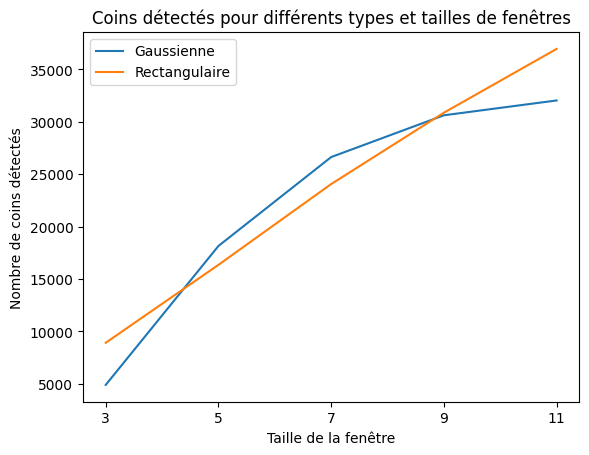

In [65]:
import matplotlib.pyplot as plt

# Définition d'un ensemble de types et de tailles de fenêtres à tester
types_fenetre = ['gaussian', 'uniform']
tailles_fenetre = [3, 5, 7, 9, 11]

# Initialisation d'une liste pour stocker le nombre de coins détectés pour chaque type et taille de fenêtre
num_corners_gaussian = []
num_corners_uniform = []

# Boucle sur tous les types et tailles de fenêtres
for window_type in types_fenetre:
    if window_type == 'gaussian':
        func = detection_harris_gauss_optimized
        num_corners = num_corners_gaussian
    else:
        func = detection_harris_rectangle
        num_corners = num_corners_uniform
    for window_size in tailles_fenetre:
        # Exécution de l'algorithme de détection de coins avec le type et la taille de fenêtre actuels
        img_corners, num_detected = func(img, 0, window_size)
        # Stockage du nombre de coins détectés
        num_corners.append(num_detected)

# Tracé du nombre de coins détectés en fonction du type et de la taille de fenêtre
fig, ax1 = plt.subplots()
ax1.plot(num_corners_gaussian, label='Gaussienne')
ax1.plot(num_corners_uniform, label='Rectangulaire')
ax1.set_xticks(range(len(tailles_fenetre)))
ax1.set_xticklabels(tailles_fenetre)
ax1.set_xlabel('Taille de la fenêtre')
ax1.set_ylabel('Nombre de coins détectés')
ax1.set_title('Coins détectés pour différents types et tailles de fenêtres')
ax1.legend()

plt.show()

#### 1) Influence du paramètre k

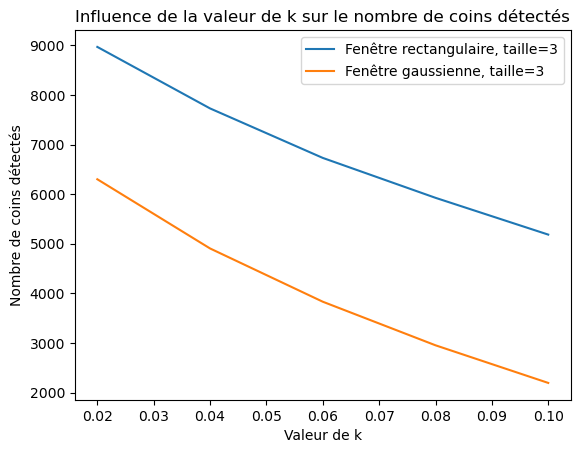

In [151]:
import matplotlib.pyplot as plt

# Différentes valeurs de k à tester
k_values = [0.02, 0.04, 0.06, 0.08, 0.1]

num_corners_rectangular = []
num_corners_gaussian = []

# Boucle sur chaque valeur de k
for k in k_values:
    # Détection des coins avec une fenêtre rectangulaire pour les différents k
    img_corners, num_detected = detection_harris_rectangle(img, 0, 3, k)
    num_corners_rectangular.append(num_detected)
    # Détection des coins avec une fenêtre gaussienne cette fois
    img_corners, num_detected = detection_harris_gauss_optimized(img, 0, 3, k)
    num_corners_gaussian.append(num_detected)

# Tracé du nombre de coins détectés pour chaque type de fenêtre en fonction de la valeur de k
plt.plot(k_values, num_corners_rectangular, label='Fenêtre rectangulaire, taille=3')
plt.plot(k_values, num_corners_gaussian, label='Fenêtre gaussienne, taille=3')
plt.legend()
plt.xlabel('Valeur de k')
plt.ylabel('Nombre de coins détectés')
plt.title('Influence de la valeur de k sur le nombre de coins détectés')
plt.show()


### Rotation de l'image

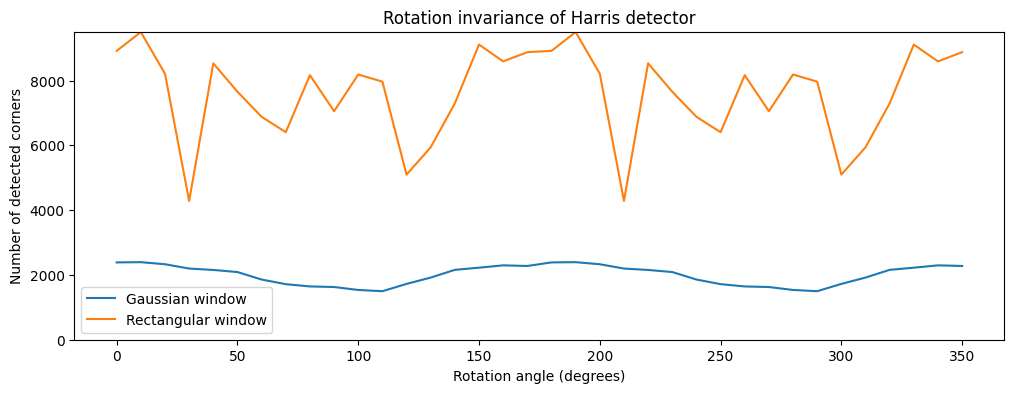

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import rotate

# Define the rotation angles to test
angles = np.arange(0, 360, 10)

# Initialize a list to store the number of detected corners for each angle
num_corners_gauss = []
num_corners_rect = []

# Apply the Harris detector for each angle and store the number of detected corners
for angle in angles:
    _, num_detected_gauss = detection_harris_gauss_optimized(img, angle,sigma=2.5)
    num_corners_gauss.append(num_detected_gauss)
    _, num_detected_rect = detection_harris_rectangle(img, angle)
    num_corners_rect.append(num_detected_rect)

# Plot the number of detected corners as a function of the rotation angle
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(angles, num_corners_gauss, label='Gaussian window')
ax.plot(angles, num_corners_rect, label='Rectangular window')
ax.set_xlabel('Rotation angle (degrees)')
ax.set_ylabel('Number of detected corners')
ax.set_title('Rotation invariance of Harris detector')
ax.legend()

max_value = max(max(num_corners_gauss), max(num_corners_rect))
ax.set_ylim([0, max_value + 10])

plt.show()


## 2 - Détecteur FAST

In [ ]:
from fast.py import *

## Méthode 1 - méthode itérative

On commence par implémenter une fonction qui récupère la valeur de l'intensité des 16 pixels du cercle autour du pixel $p_0$ que l'on cherche à tester.

In [11]:
''' Cette fonction permet de calculer les points d'un cercle de rayon 3
autour d'un point de coordonnées (ligne,col) et de renvoyer les coordonnées
de ces points dans une liste'''

def cercle(ligne: int, col: int) -> np.ndarray :
    

    pt = [(ligne-3, col),(ligne-3, col+1),(ligne-2, col+2),(ligne-1, col+3),(ligne, col+3),(ligne+1, col+3),
          (ligne+2, col+2),(ligne+3, col+1),(ligne+3, col),(ligne+3, col-1),(ligne+2, col-2),(ligne+1, col-3),
          (ligne, col-3),(ligne-1, col-3),(ligne-2, col-2),(ligne-3, col-1)]
    return pt

print(cercle(33,33))


[(30, 33), (30, 34), (31, 35), (32, 36), (33, 36), (34, 36), (35, 35), (36, 34), (36, 33), (36, 32), (35, 31), (34, 30), (33, 30), (32, 30), (31, 31), (30, 32)]


Puis, on implémente la fonction capable de comparer l'intensité des différents points du cercle autour de p0. Si n pixels consécutifs du cercle ont une intensité suffisamment différente de celle de p0, la fonction renvoie True.

In [25]:
''' Cette fonction permet de comparer l'intensité du point p0 avec les points du cercle'''

def compare_Intensity(image: np.ndarray, pt_cercle: list, I_p0: float, t: float, n: int):
    sup_nb = 0

    # On commence par comparer l'intensité des pixels 1, 5, 9 et 13 avec p0 pour gagner en efficacité
    # Cela nous permet d'exclure directement une bonne partie des pixels qui ne sont pas des points d'intérêt
    for pt in (pt_cercle[0], pt_cercle[4], pt_cercle[8], pt_cercle[12]):
        if (image[pt[0]][pt[1]] > I_p0 + t) or (image[pt[0]][pt[1]] < I_p0 - t):
            sup_nb += 1     # on compte le nombre de points parmis les 4, dont l'intensité est supérieure à celle du point p0
    if sup_nb >= 3:       # si ce nombre est supérieur ou égal à 3, il s'agit peut-être d'un point d'intérêt
        # Dans ce cas, on continue la vérification
        for pt in pt_cercle:
            if (image[pt[0]][pt[1]] > t + I_p0) or (image[pt[0]][pt[1]] < I_p0 - t):
                sup_nb += 1     # on compte le nombre de points du cercle dont l'intensité est suffisamment différente de celle du point p0
                if sup_nb >= n:
                    return True # si ce nombre est supérieur au paramètre n (à initialiser), on renvoie True, il s'agit d'un point d'intérêt
            else :
                sup_nb = 0 # on veut n points CONSECUTIFS
        return False     # si on sort de celle boucle sans avoir vu 12 pixels consécutifs qui vérifient l'assertion, on renvoie False, ce n'est pas un point d'intérêt
    else :
        return False  # ce n'est pas un point d'intérêt
    

Enfin, on implémente la fonction $fast()$ qui utilise les deux fonctions précédentes pour chaque pixel de l'image (sauf ceux qui ce trouve aux extrémités de l'image et pour lesquels on ne peut pas tracer un cercle complet). Si $compare\_ Intensity()$ renvoie True, la fonction $fast()$ marque le point d'intérêt en rouge.

In [67]:

def fast_1(image_path: np.ndarray, t: float, n: int, rot: int):
    
    image = imread(image_path)

    if rot != 0 :
        image= ndi.rotate(image,rot, reshape=False)
    
    img_gray=rgb2gray(image)

    count = 0 # nombre de pt d'intérêt


    #x,y = neshjrid
    #xN = x +[0,1,2,3,3,3,2,1,0,-1,-2,-3,-3,-3,-2,1]
    #yN = y +[3,3,2,1,0,-1,-2,-3,-3,-3,-2,-1,0,1,2,3]
    #imgN = img.flatten()[xN*img.shape(1)+yN]
    


    width = np.shape(image)[1] # largeur et hauteurs de l'image
    height = np.shape(image)[0]
    x, y = 0, 0

    img_gray=rgb2gray(image)
    
    img_copy_for_FAST = np.copy(image)

    for x in range(3,height-3): 
        for y in range(3,width-3):
            
            pt_cercle = cercle(x,y)
            I_p0 = img_gray[x][y]

            if compare_Intensity(img_gray, pt_cercle, I_p0, t, n):
                img_copy_for_FAST[x][y] = [255,0,0]
                count += 1
            
            if((y+3)%width == 0):
                break
            
    
    return img_copy_for_FAST, count

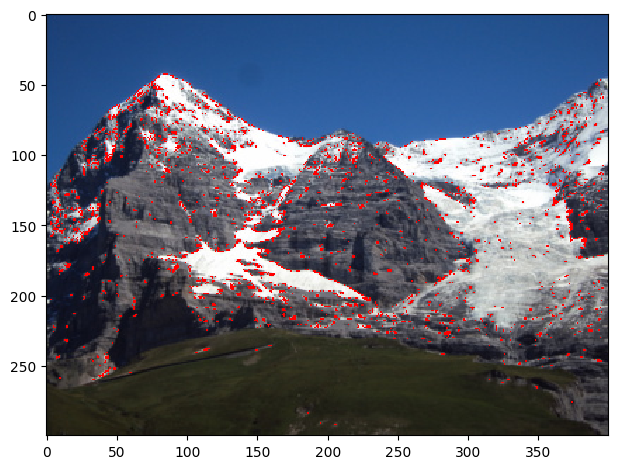

In [68]:
''' TEST de la méthode FAST '''

img_FAST, _ = fast_1("M1.JPG", 0.09, 12, 0)

imshow(img_FAST)

## Méthode 2 - méthode avec filtres

Il existe également des méthodes de Machine Learning qui permette d'optimiser encore d'avantage la méthode FAST [3]

### Suppression des non-maxima locaux pour FAST

400
400


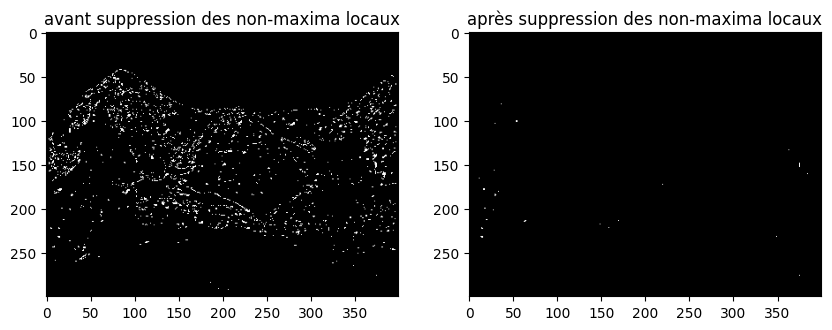

In [59]:

image = imread("M1.JPG")
gray=rgb2gray(image)

img_FAST, _ = fast_1("M1.JPG", 0.1, 12, 0)
new_FAST_image,c = sup_non_maxima_optimized(img_FAST, "M1.JPG")


### Affichage de la différence avec/sans maxima locaux

new_FAST_image = image - new_FAST_image
new_FAST_image[new_FAST_image < 0] = 0
new_FAST_image[new_FAST_image > 0] = 255

img_FAST = image - img_FAST
img_FAST[img_FAST < 0] = 0
img_FAST[img_FAST > 0] = 255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img_FAST, cmap='gray')
ax1.set_title('avant suppression des non-maxima locaux')
ax2.imshow(new_FAST_image, cmap='gray')
ax2.set_title('après suppression des non-maxima locaux')
plt.show()


## FAST : Rotation de l'image

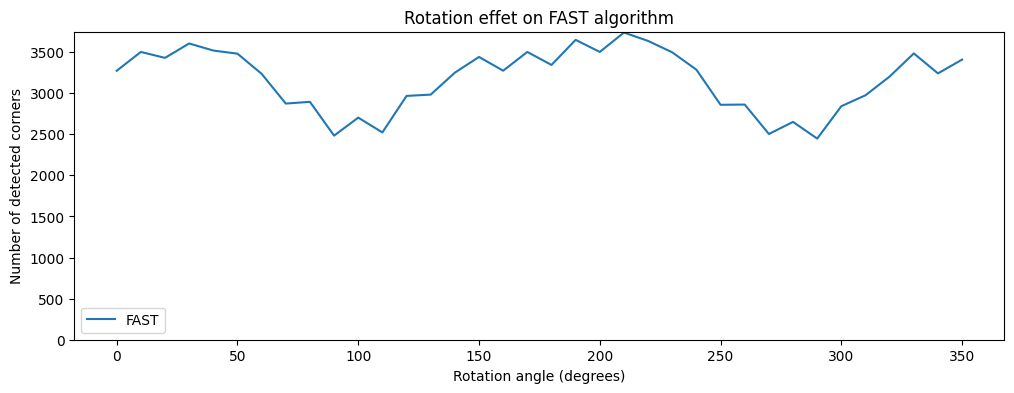

Le nombre max de détection est : 3737 ; le nombre min de détection est : 2447


In [74]:
# Définition des angles de rotation à tester
angles = np.arange(0, 360, 10)

# Initialiser une liste pour stocker le nombre de coins détectés pour chaque angle
num_corners_fast = []

# Appliquer le détecteur FAST pour chaque angle et enregistrer le nombre de coins détectés.
for angle in angles:
    _, num_detected_fast = fast_1(img, 0.1, 12, angle)
    num_corners_fast.append(num_detected_fast)

# Tracer le nombre de coins détectés en fonction de l'angle de rotation
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(angles, num_corners_fast, label='FAST')
ax.set_xlabel('Rotation angle (degrees)')
ax.set_ylabel('Number of detected corners')
ax.set_title('Rotation effet on FAST algorithm')
ax.legend()

max_value = max(num_corners_fast)
min_value = min(num_corners_fast)

ax.set_ylim([0, max_value + 10])

plt.show()

print("Le nombre max de détection est :", max_value, "; le nombre min de détection est :", min_value)

### Commentaire :

Nous pouvons constater que le détecteur FAST n'est pas invariant par rotation. Le nombre de détection va de 2447 pour le minimum à 3737 pour le maximum. Il y a donc 1290 détections de différence, ce qui est loin d'être anecdotique comme pour la fenêtre Gaussienne. De plus, la fonction du nombre de détections en fonction de l'angle semble être périodique.



# Exercice 2 : Description et matching des points d'intérêt

In [33]:
# Nouvelle fonction FAST qui renvoie un vecteur de points d'intérêt

def fast_for_matching(image_path: np.ndarray, t: float, n: int, rot: int) -> np.ndarray:
    
    image = imread(image_path)

    if rot != 0 :
        image= ndi.rotate(image,rot, reshape=False)
    img_gray=rgb2gray(image)

    #x,y = neshjrid
    #xN = x +[0,1,2,3,3,3,2,1,0,-1,-2,-3,-3,-3,-2,1]
    #yN = y +[3,3,2,1,0,-1,-2,-3,-3,-3,-2,-1,0,1,2,3]
    #imgN = img.flatten()[xN*img.shape(1)+yN]


    width = np.shape(image)[1] # largeur et hauteurs de l'image
    height = np.shape(image)[0]
    x, y = 0, 0
    vect_pt_interet = []

    img_gray=rgb2gray(image)
    
    img_copy_for_FAST = np.copy(image)

    for x in range(3,height-3): 
        for y in range(3,width-3):
            
            pt_cercle = cercle(x,y)
            I_p0 = img_gray[x][y]

            if compare_Intensity(img_gray, pt_cercle, I_p0, t, n):
                vect_pt_interet.append((x,y))    # on rentre les coordonnées des pt d'intérêt
                                                 # dans un vecteur au lieu de colorer l'image en rouge
            if((y+3)%width == 0):
                break
    
    return(vect_pt_interet)
            


In [35]:
def bloc_descriptor(img_path1, img_path2, taille_bloc ,type_methode : int):


    # récupérer les points d'intérêt (img 1 et 2)

    vect_interet_1 = fast_for_matching(img_path1, 0.09, 12, 0) 
    vect_interet_2 = fast_for_matching(img_path2, 0.09, 12, 0) 
    taille_vect1 = np.shape(vect_interet_1)[0]
    taille_vect2 = np.shape(vect_interet_2)[0]

    # créer n1+n2 vecteurs de bloc (avec n1, n2 = le nombre de points d'intérêt dans img 1 et 2 resp)
    # On stock ces vecteurs sous forme de matrice. Les deux matrices sont vecteurs_de_bloc_1 et 2. Une matrice par image.

    vecteurs_de_bloc_1 = []
    vecteurs_de_bloc_2 = []

    for i in range(taille_vect1):
        (x,y)=vect_interet_1[i]
        intvect1 = [img_gray[x][y],img_gray[x-1][y],img_gray[x+1][y],img_gray[x-1][y-1],img_gray[x+1][y-1],img_gray[x][y-1],img_gray[x][y+1],img_gray[x-1][y+1],img_gray[x+1][y+1]]
        # pour l'instant on observe juste les plus proches voisins
        vecteurs_de_bloc_1.append(intvect1)
    for i in range(taille_vect2):
        (x,y)=vect_interet_2[i]
        intvect2 = [img_gray[x][y],img_gray[x-1][y],img_gray[x+1][y],img_gray[x-1][y-1],img_gray[x+1][y-1],img_gray[x][y-1],img_gray[x][y+1],img_gray[x-1][y+1],img_gray[x+1][y+1]]
        # pour l'instant on observe juste les plus proches voisins
        vecteurs_de_bloc_2.append(intvect2)


    # Suppression des mauvais match : appariement croisé pour chaque pt d'intérêt

    dist1 = []
    dist2 = []
    min_dist1 = []
    min_dist2 = []
    size_vecteurs_bloc_1 = np.shape(vecteurs_de_bloc_1)
    size_vecteurs_bloc_2 = np.shape(vecteurs_de_bloc_2)
    print(size_vecteurs_bloc_1)

    for i in range(size_vecteurs_bloc_1[0]):
        for j in range(size_vecteurs_bloc_2[0]):
            somme = 0
            for k in range(size_vecteurs_bloc_1[1]):
                somme+=np.abs(vecteurs_de_bloc_1[i][k] - vecteurs_de_bloc_2[j][k])
            dist1.append(somme)
        min_dist1.append(np.argmin(dist1)) # On récupère l'indice de la valeur minimum de distance qui pointe vers 
                                           # le point d'intérêt de l'image 2 qui match le point d'intérêt de l'image 1

    for i in range(size_vecteurs_bloc_2[0]):
        for j in range(size_vecteurs_bloc_1[0]):
            somme = 0
            for k in range(size_vecteurs_bloc_2[1]):
                somme+=np.abs(vecteurs_de_bloc_2[i][k] - vecteurs_de_bloc_1[j][k])
            dist2.append(somme)
        min_dist2.append(np.argmin(dist2)) # On récupère l'indice de la valeur minimum de distance qui pointe vers 
                                           # le point d'intérêt de l'image 1 qui match le point d'intérêt de l'image 2
    

    for i in range(len(min_dist1)):
        if(min_dist1[i] != min_dist2[i]):

            del(vect_interet_1[min_dist1[i]])  # On supprime les points d'interet qui ont des mauvais appariements
            del(vect_interet_2[min_dist2[i]])  # des liste vect_interet_1 et 2
            del(vecteurs_de_bloc_1[min_dist1[i]])
            del(vecteurs_de_bloc_2[min_dist2[i]])
            del(min_dist1[i])
            del(min_dist2[i])


    # Appariement des points d'intérêt : 

    appariement = []

    for m in range(len(min_dist1)):
        appariement.append((vect_interet_1[m], vect_interet_2[min_dist1[m]]))

    return appariement
    

    

In [36]:

print(bloc_descriptor("M1.JPG", "M2.JPG", 0, 0))

(11546, 9)


KeyboardInterrupt: 